##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Delta Orthogonal Convolution Tutorial
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Initialization

In [9]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import warnings

from scipy.integrate import quad, dblquad
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Helper functions and class for mean field calculations.

In [0]:
def gauss_density(x):
  return np.exp(-x**2/2)/np.sqrt(2*np.pi)

def d_tanh(x):
  """Derivative of tanh."""
  return 1./ np.cosh(x)**2

In [0]:
class MeanField(object):
  def __init__(self, f, df):
    """
    Args: 
      f: activation function
      df: derivative of f. 
    """
    self.f = f
    self.df = df
  
  def qmap_density(self, x, q):
    """Compute the density function of the q-map."""
    return (self.f(np.sqrt(q)*x)**2)* gauss_density(x)
  
  def chi_density(self, x, q):
    return gauss_density(x) * (self.df(np.sqrt(q)*x)**2) 
  
  def sw_sb(self, q, chi1):
    """Compute the critical line. Set chi1=1, return variances of weight and 
       bias on the critical line with qstar=q.
    """
    big_val = 1e12
    with warnings.catch_warnings():
      warnings.simplefilter("ignore") # silence underflow and overflow warning
      sw = chi1/quad(self.chi_density, -np.inf, np.inf, args= (q))[0]
      sb = q - sw * quad(self.qmap_density, -np.inf, np.inf, args= (q))[0]
    return sw, sb

# Phase diagram

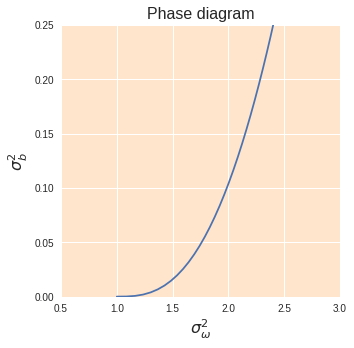

In [5]:
background = [255.0/255.0, 229/255.0, 204/255.0]
fontsize=16

mf = MeanField(np.tanh, d_tanh)
n = 50
qrange = np.linspace(1e-5, 2.25, n)

sw = [mf.sw_sb(q, 1)[0] for q in qrange]
sb = [mf.sw_sb(q, 1)[1] for q in qrange]


plt.figure(figsize=(5, 5))
plt.plot(sw, sb)
plt.xlim(0.5, 3)
plt.ylim(0, 0.25)
plt.title('Phase diagram', fontsize=fontsize)
plt.xlabel('$\sigma_\omega^2$', fontsize=fontsize)
plt.ylabel('$\sigma_b^2$', fontsize=fontsize)

plt.gca().set_facecolor(background)
plt.gcf().set_size_inches(plt.gcf().get_size_inches()[1], plt.gcf().get_size_inches()[1])


# Train Delta Orthogonal Network

In [0]:
# DEPTH and C_SIZE are chosen to be small for a fast running demo. You will want
# to increase both values for most use cases.
# Further note: this will run *much faster* if you choose a runtime with a GPU
# accelerator.
DEPTH = 16 # number of layers.
C_SIZE = 32 # channel size.
K_SIZE = 3 # kernel size
LEARNING_RATE = 1e-2
MOMENTUM = 0.95
phi = tf.tanh # non-linearity

# variances of weight and bias. 
# To obtain critical values of the variances of the weights and biases,
# see compute mean field below.  
mf = MeanField(np.tanh, d_tanh)
qstar = 1./DEPTH
W_VAR, B_VAR = mf.sw_sb(qstar, 1)


def circular_padding(input_, width, kernel_size):
  """Padding input_ for computing circular convolution."""
  begin = kernel_size // 2
  end = kernel_size - 1 - begin
  tmp_up = tf.slice(input_, [0, width - begin, 0, 0], [-1, begin, width, -1])
  tmp_down = tf.slice(input_, [0, 0, 0, 0], [-1, end, width, -1])
  tmp = tf.concat([tmp_up, input_, tmp_down], 1)
  new_width = width + kernel_size - 1
  tmp_left = tf.slice(tmp, [0, 0, width - begin, 0], [-1, new_width, begin, -1])
  tmp_right = tf.slice(tmp, [0, 0, 0, 0], [-1, new_width, end, -1])
  return  tf.concat([tmp_left, tmp, tmp_right], 2)

def conv2d(x, w, strides=1, padding='SAME'):
  return tf.nn.conv2d(x, w, strides=[1, strides, strides, 1], padding=padding)

def get_weight(shape, std=1., name=None):
  return tf.Variable(tf.random_normal(shape, mean=0, stddev=std), name=name)

def get_orthogonal_weight(name, shape, gain=1.):
  # Can also use tf.contrib.framework.convolutional_orthogonal_2d
  return tf.get_variable(name, shape=shape,
     initializer=tf.contrib.framework.convolutional_delta_orthogonal(gain=gain))

def conv_model(x):
  """Convolutional layers. Ouput logits. """
  z = tf.reshape(x, [-1,28,28,1])
  # Increase the channel size to C_SIZE.
  std = np.sqrt(W_VAR / (K_SIZE**2 * 1))
  kernel = get_weight([K_SIZE, K_SIZE, 1, C_SIZE], std=std, name='kernel_0')
  bias = get_weight([C_SIZE], std=np.sqrt(B_VAR), name='bias_0')
  h = conv2d(z, kernel, strides=1, padding='SAME') + bias
  z = phi(h)
  
  # Reducing spacial dimension to 7 * 7; applying conv with stride=2 twice.
  std = np.sqrt(W_VAR / (K_SIZE**2 * C_SIZE))
  shape = [K_SIZE, K_SIZE, C_SIZE, C_SIZE]
  for j in range(2):
    kernel = get_weight(shape, std=std, name='reduction_{}_kernel'.format(j))
    bias = get_weight([C_SIZE], std=np.sqrt(B_VAR),
                      name='reduction_{}_bias'.format(j))
    h = conv2d(z, kernel, strides=2) + bias
    z = phi(h)
  new_width = 7 # width of the current image after dimension reduction. 
  
  # A deep convolution block with depth=DEPTH.
  std = np.sqrt(W_VAR)
  for j in range(DEPTH):
    name = 'block_conv_{}'.format(j)
    kernel_name, bias_name = name + 'kernel', name + 'bias'
    kernel = get_orthogonal_weight(kernel_name, shape, gain=W_VAR)
    bias = get_weight([C_SIZE], std=np.sqrt(B_VAR), name=bias_name)
    z_pad = circular_padding(z, new_width, K_SIZE)
    h = conv2d(z_pad, kernel, padding='VALID') + bias
    z = phi(h)
  z_ave = tf.reduce_mean(z, [1, 2])
  logit_W = get_weight([C_SIZE, 10], std=np.sqrt(1./(C_SIZE)))
  logit_b = get_weight([10], std=0.)
  return tf.matmul(z_ave, logit_W) + logit_b

def loss(logits, labels):
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))

def train_op(loss_, learning_rate, global_step):
  with tf.control_dependencies([tf.assign(global_step, global_step + 1)]):
    return tf.train.MomentumOptimizer(learning_rate, MOMENTUM).minimize(loss_)

def accuracy(logits, labels):
  return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1),
                                         tf.argmax(labels, 1)), 
                                tf.float32))

def run_model(num_steps=1000):
  tf.reset_default_graph()
  accuracy_log = []
  loss_log = []
  x = tf.placeholder(tf.float32, shape=[None, 784])
  y_ = tf.placeholder(tf.float32, shape=[None, 10])
  global_step = tf.train.get_or_create_global_step()
  logits = conv_model(x)
  acc, loss_ = accuracy(logits, y_), loss(logits, y_)
  training = train_op(loss_, LEARNING_RATE, global_step)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_steps):
      batch_xs, batch_ys = mnist.train.next_batch(100)
      _, acc_value, loss_value, g_step = sess.run(
          [training, acc, loss_, global_step], 
          feed_dict={x:batch_xs, y_:batch_ys})
      accuracy_log.append(acc_value)
      loss_log.append(loss_value)
      if i % (num_steps/20) == 0 or i == num_steps-1:
        print('Step: %5d Accuracy: %.2f Loss: %g'%(g_step, acc_value, loss_value))
  return accuracy_log, loss_log


In [7]:
accuracy_log, loss_log = run_model()

Step:     0 Accuracy: 0.07 Loss: 2.30505
Step:    51 Accuracy: 0.26 Loss: 1.97781
Step:   100 Accuracy: 0.24 Loss: 1.85622
Step:   150 Accuracy: 0.38 Loss: 1.48279
Step:   200 Accuracy: 0.51 Loss: 1.39135
Step:   250 Accuracy: 0.46 Loss: 1.28701
Step:   300 Accuracy: 0.50 Loss: 1.27826
Step:   350 Accuracy: 0.61 Loss: 1.11567
Step:   400 Accuracy: 0.56 Loss: 0.869806
Step:   450 Accuracy: 0.80 Loss: 0.696834
Step:   500 Accuracy: 0.71 Loss: 0.76464
Step:   550 Accuracy: 0.89 Loss: 0.48842
Step:   600 Accuracy: 0.89 Loss: 0.536567
Step:   651 Accuracy: 0.92 Loss: 0.291886
Step:   700 Accuracy: 0.97 Loss: 0.152038
Step:   750 Accuracy: 0.93 Loss: 0.252104
Step:   800 Accuracy: 0.95 Loss: 0.204787
Step:   850 Accuracy: 0.93 Loss: 0.214044
Step:   900 Accuracy: 0.97 Loss: 0.14412
Step:   950 Accuracy: 0.98 Loss: 0.144498
Step:   999 Accuracy: 0.93 Loss: 0.182756


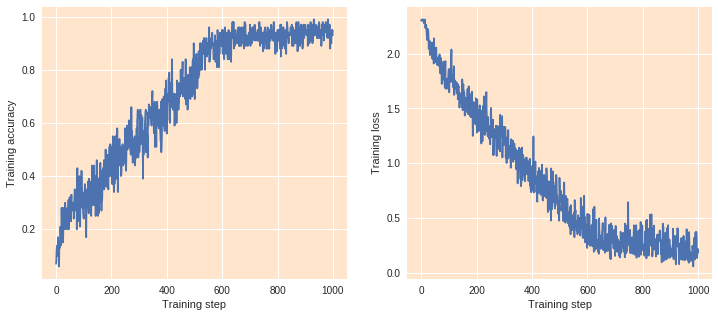

In [8]:
background = [255.0/255.0, 229/255.0, 204/255.0]

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(accuracy_log)
plt.xlabel('Training step')
plt.ylabel('Training accuracy')
plt.gca().set_facecolor(background)

plt.subplot(1,2,2)
plt.plot(loss_log)
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.gca().set_facecolor(background)